In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
import numpy as np

In [3]:
import glob, os
import re

## File paths

In [4]:
glob_list = []

#loop through subject folders and glob
for subject in range(25):
    glob_list.append(glob.glob(str(subject) + "\\[A-Z0-9]*.csv"))
    
#function to flatten glob
flatten = lambda l: [item for sublist in l for item in sublist]
glob_list = flatten(glob_list)

In [5]:
#make a list of tuples of hand pairings
lr_pairs = list(zip(*[iter(glob_list)]*2))

# remove all blue files
for i in range(25):
    lr_pairs.remove((str(i)+'\\Blue_Left.csv', str(i)+'\\Blue_Right.csv'))
# remove "bad" from subject 19
lr_pairs.remove(('19\\Bad_Left.csv', '19\\Bad_Right.csv'))

## Create list of DataFrames

In [6]:
df_list = []

for pair in lr_pairs:
    df_left = pd.read_csv(pair[0], index_col=None).drop(['Unnamed: 0'], axis = 1)
    df_right = pd.read_csv(pair[1], index_col=None).drop(['Unnamed: 0'], axis = 1)
    
    #rename columns
    df_left = df_left.add_prefix('left')
    df_right = df_right.add_prefix('right')
    
    #merge
    df = pd.merge(df_left, df_right, left_on='leftTime', right_on='rightTime').drop('rightTime', axis = 1)

    #covert fist column to time object
    df['leftTime'] = pd.to_datetime(df['leftTime'].str[:-3], format = '%H:%M:%S.%f')
    
    #difference between rows
    df = df.diff().iloc[1:]
    df['leftTime'] = df['leftTime'].dt.total_seconds()
    
    df.rename(columns={'leftTime':'time'}, inplace=True)
    
    #add sign and subject using regex of file name
    subject_sign = re.split(r'\\', re.findall('^[^_]+(?=_)', pair[0])[0])
    df.insert(loc = 0, column = 'Subject', value = subject_sign[0])
    df.insert(loc = 0, column = 'Sign', value = subject_sign[1])
    
    df_list.append(df)

## Hand Classification

In [165]:
hands_used  = pd.read_csv("signs_f.csv")
# two_hand = hands_used[hands_used.Both_Hands.notnull()].Sign.values
# one_hand = hands_used[hands_used.Both_Hands.isnull()].Sign.values

In [68]:
threshold = [(abs(df.iloc[:,3:].filter(regex='left').mean().sum()), df.loc[1, 'Sign']) for df in df_list]

In [161]:
thresh = .000025

In [162]:
one_hand = [tup[1] for tup in threshold if tup[0] < thresh]
one_hand = list(set(one_hand))

In [170]:
two_hand = [value for value in hands_used.Sign.values if value not in one_hand]

In [171]:
class hand_selection:
    
    def __init__(self, drop_left=False):
        self.drop_left = drop_left
        
    def transform(self, df_list, hand_list):
        if not self.drop_left:
            subset = [df for df in df_list if df.Sign.values[0] in hand_list]
        else:
            subset = [df.drop(df.filter(regex='left').columns, axis=1) \
                      for df in df_list \
                      if df.Sign.values[0] in hand_list]
            
        return subset

## Feature Extraction

In [172]:
class extraction:
    def __init__(self, df):
        self.df = df
        self.features = dict()
        
    def label(self):
        self.features['label'] = self.df['Sign'].iloc[0]
        self.df = self.df.iloc[:, 2:]
        
    def mean(self):
        for col in self.df:
            self.features[col + ' mean'] = self.df[col].mean()
            
    def stdev(self):
        for col in self.df:
            self.features[col + ' stdev'] = self.df[col].std()
            
    def extract_features(self):
        self.label()
        self.mean()
        self.stdev()

In [173]:
from sklearn.preprocessing import StandardScaler

def return_features(df_list, hand_list, drop_left):
    scaler = StandardScaler()
    
    feature_list = []
    
    select_class = hand_selection(drop_left)
    frames = select_class.transform(df_list, hand_list)
    
    for df in frames:
        class_obj = extraction(df)
        class_obj.extract_features()
        feature_list.append(class_obj.features)
        
    feat_df = pd.DataFrame(feature_list)
    
    y = feat_df.label
    X = scaler.fit_transform(feat_df.drop(['label'], axis = 1))
    
    return X, y

In [174]:
X_one_hand, y_one_hand = return_features(df_list=df_list, 
                                         hand_list=one_hand, 
                                         drop_left=True)

X_two_hand, y_two_hand = return_features(df_list=df_list, 
                                         hand_list=two_hand, 
                                         drop_left=False)

## Model Selection

In [175]:
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

### Two Hand

In [176]:
import warnings
warnings.filterwarnings('ignore')

lda_accuracy = []
qda_accuracy = []
knn_accuracy = []
rf_accuracy = []
nb_accuracy = []

for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X_two_hand, 
                                                        y_two_hand,
                                                        stratify=y_two_hand, 
                                                        test_size=0.25)

    clf = LinearDiscriminantAnalysis()
    clf.fit(X_train, y_train)
    lda_accuracy.append(clf.score(X_test,y_test))
    
    clf = QuadraticDiscriminantAnalysis()
    clf.fit(X_train, y_train)
    qda_accuracy.append(clf.score(X_test,y_test))
    
    neigh = KNeighborsClassifier(n_neighbors=15)
    neigh.fit(X_train, y_train)
    knn_accuracy.append(neigh.score(X_test,y_test))    
    
    clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
    clf.fit(X_train, y_train)
    rf_accuracy.append(clf.score(X_test,y_test))

    clf = GaussianNB()
    clf.fit(X_train, y_train)
    nb_accuracy.append(clf.score(X_test,y_test))    

In [177]:
accuracy_list = [qda_accuracy, nb_accuracy, knn_accuracy, rf_accuracy, lda_accuracy]

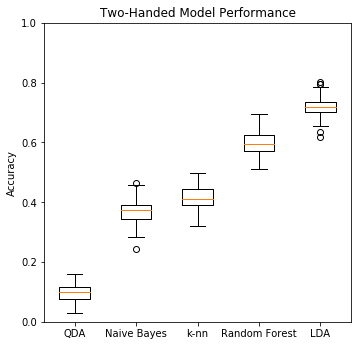

In [178]:
plt.figure(figsize=(5.5, 5.5))
plt.ylim(0, 1)
plt.boxplot(accuracy_list, labels = ['QDA', 'Naive Bayes', 'k-nn', 'Random Forest', 'LDA'])
plt.title('Two-Handed Model Performance')
plt.ylabel('Accuracy')
plt.show()

### One Hand

In [179]:
lda_accuracy = []
qda_accuracy = []
knn_accuracy = []
rf_accuracy = []
nb_accuracy = []

for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X_one_hand, 
                                                        y_one_hand,
                                                        stratify=y_one_hand, 
                                                        test_size=0.25)

    clf = LinearDiscriminantAnalysis()
    clf.fit(X_train, y_train)
    lda_accuracy.append(clf.score(X_test,y_test))
    
    clf = QuadraticDiscriminantAnalysis()
    clf.fit(X_train, y_train)
    qda_accuracy.append(clf.score(X_test,y_test))
    
    neigh = KNeighborsClassifier(n_neighbors=15)
    neigh.fit(X_train, y_train)
    knn_accuracy.append(neigh.score(X_test,y_test))    
    
    clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
    clf.fit(X_train, y_train)
    rf_accuracy.append(clf.score(X_test,y_test))

    clf = GaussianNB()
    clf.fit(X_train, y_train)
    nb_accuracy.append(clf.score(X_test,y_test))    

In [180]:
accuracy_list = [qda_accuracy, nb_accuracy, knn_accuracy, rf_accuracy, lda_accuracy]

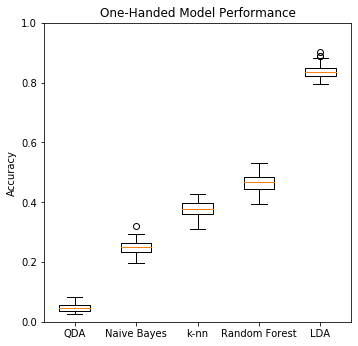

In [181]:
plt.figure(figsize=(5.5, 5.5))
plt.ylim(0, 1)
plt.boxplot(accuracy_list, labels = ['QDA', 'Naive Bayes', 'k-nn', 'Random Forest', 'LDA'])
plt.title('One-Handed Model Performance')
plt.ylabel('Accuracy')
plt.show()

## Model

### Two Hand

In [182]:
import warnings
warnings.filterwarnings('ignore')

accuracy = []

for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X_two_hand, 
                                                        y_two_hand,
                                                        stratify=y_two_hand, 
                                                        test_size=0.25)

    clf = LinearDiscriminantAnalysis()
    clf.fit(X_train, y_train)
    #clf.scalings_
    accuracy.append(clf.score(X_test,y_test))

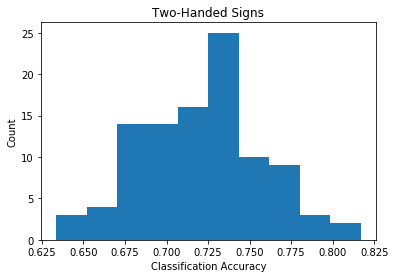

In [183]:
plt.hist(accuracy, bins=10)
plt.xlabel("Classification Accuracy")
plt.ylabel("Count")
plt.title("Two-Handed Signs")
plt.show()

### One Hand

In [184]:
accuracy = []

for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X_one_hand, 
                                                        y_one_hand,
                                                        stratify=y_one_hand, 
                                                        test_size=0.25)

    clf = LinearDiscriminantAnalysis()
    clf.fit(X_train, y_train)
    #clf.scalings_
    accuracy.append(clf.score(X_test,y_test))

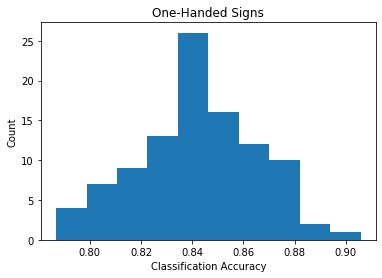

In [185]:
plt.hist(accuracy, bins=10)
plt.xlabel("Classification Accuracy")
plt.ylabel("Count")
plt.title("One-Handed Signs")
plt.show()

## Confusion

In [186]:
X_train, X_test, y_train, y_test = train_test_split(X_two_hand, 
                                                    y_two_hand,
                                                    stratify=y_two_hand, 
                                                    test_size=0.25,
                                                    random_state = 42)

clf = LinearDiscriminantAnalysis()
clf.fit(X_train, y_train)

two_hand_pred = pd.DataFrame(zip(y_test, clf.predict(X_test)), columns=['actual', 'predicted'])

clf.score(X_test,y_test)

0.7557251908396947

In [187]:
X_train, X_test, y_train, y_test = train_test_split(X_one_hand, 
                                                    y_one_hand,
                                                    stratify=y_one_hand, 
                                                    test_size=0.25,
                                                    random_state = 42)

clf = LinearDiscriminantAnalysis()
clf.fit(X_train, y_train)

one_hand_pred = pd.DataFrame(zip(y_test, clf.predict(X_test)), columns=['actual', 'predicted'])

clf.score(X_test,y_test)

0.8360655737704918

In [188]:
combined_pred = pd.concat([one_hand_pred, two_hand_pred])

In [189]:
misclass = combined_pred[combined_pred.actual != combined_pred.predicted]

Number of times a sign is misclassified (False Negative):

In [190]:
pd.DataFrame(misclass.groupby(['actual'])[['predicted']].agg('count')['predicted'].sort_values(ascending = False)).iloc[:10]

,predicted
actual,
Come,4
10,3
Store,3
Cost,3
Coat,3
More,3
Pig,3
Bug,3
Red,3


Number of times a sign is incorrectly assigned (False Poitive):

In [191]:
pd.DataFrame(misclass.groupby(['predicted'])[['predicted']].agg('count')['predicted'].sort_values(ascending = False)).iloc[:10]

,predicted
predicted,
Neutral,4
Cold,4
With,4
Cry,4
Deaf,3
Big,3
9,3
Hurt,3
More,3


## One Versus All ROC Curves

### Two Hand

In [192]:
from sklearn.multiclass import OneVsRestClassifier

In [193]:
from sklearn.preprocessing import label_binarize

X_train, X_test, y_train, y_test = train_test_split(X_two_hand, 
                                                    label_binarize(y_two_hand, classes=two_hand),
                                                    stratify=label_binarize(y_two_hand, classes=two_hand), 
                                                    test_size=0.25,
                                                    random_state = 42)

clf = OneVsRestClassifier(LinearDiscriminantAnalysis())
clf.fit(X_train, y_train)

y_score = clf.fit(X_train, y_train).decision_function(X_test)

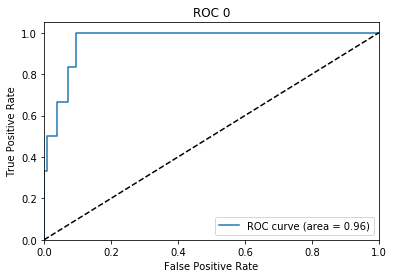

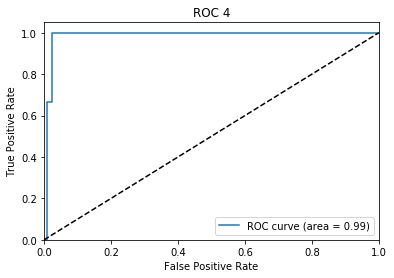

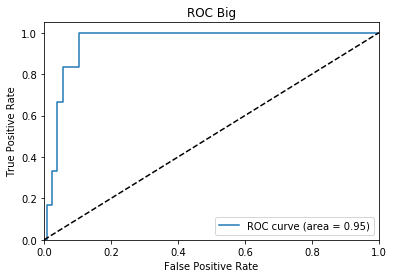

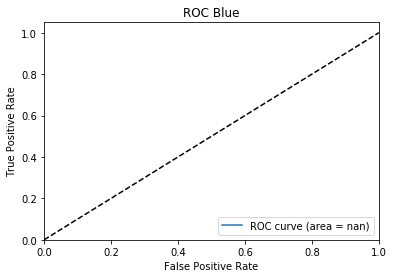

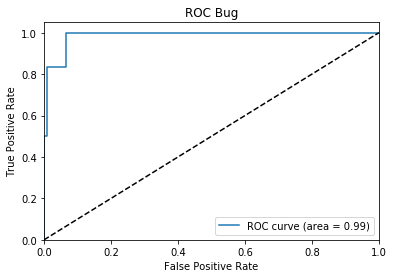

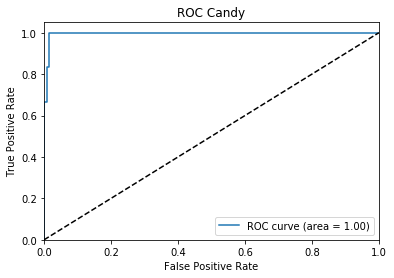

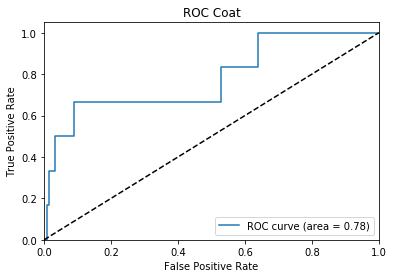

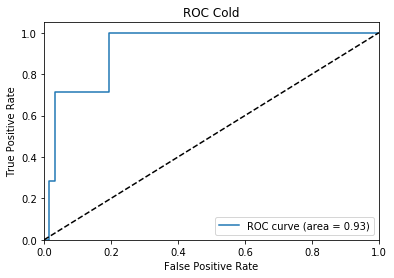

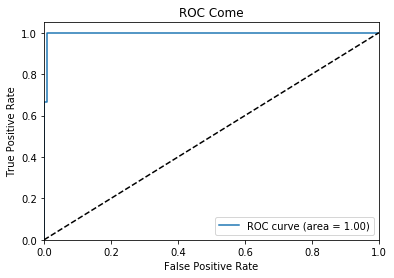

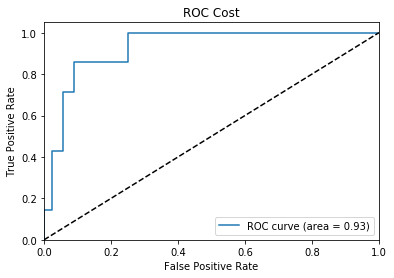

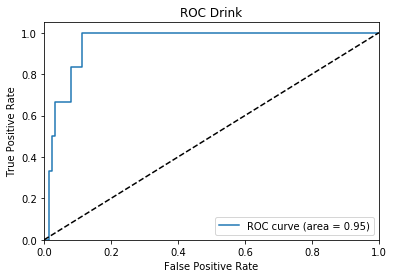

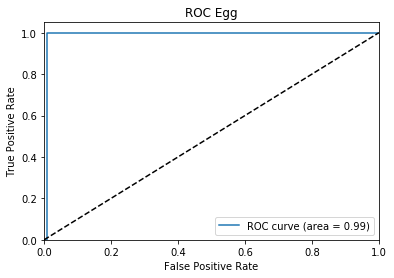

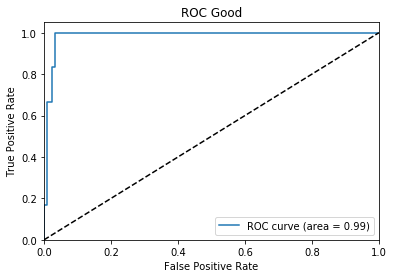

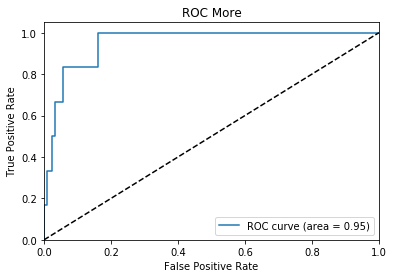

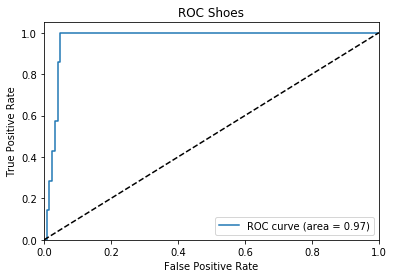

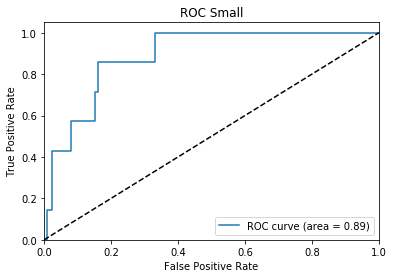

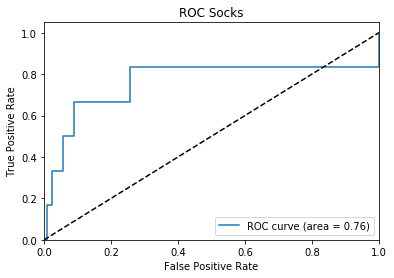

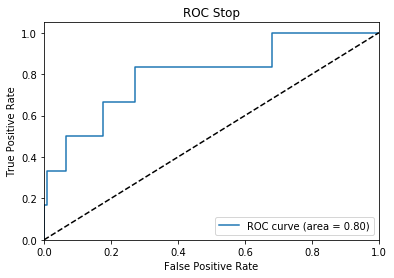

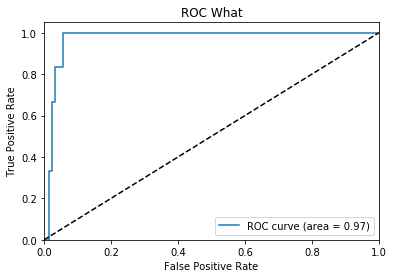

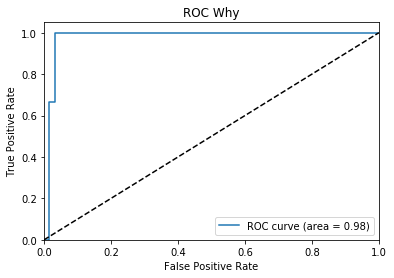

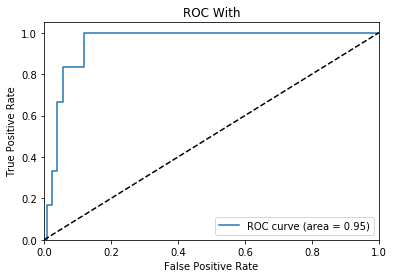

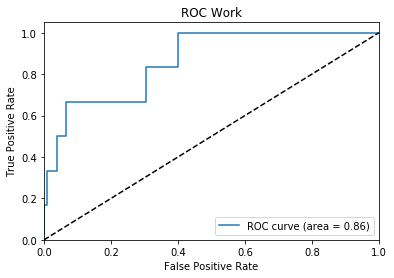

In [194]:
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt

labels = two_hand
n_classes = len(labels)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC ' + labels[i])
    plt.legend(loc="lower right")
    plt.show()

### One Hand

In [195]:
X_train, X_test, y_train, y_test = train_test_split(X_one_hand, 
                                                    label_binarize(y_one_hand, classes=one_hand),
                                                    stratify=label_binarize(y_one_hand, classes=one_hand), 
                                                    test_size=0.25,
                                                    random_state = 42)

clf = OneVsRestClassifier(LinearDiscriminantAnalysis())
clf.fit(X_train, y_train)

y_score = clf.fit(X_train, y_train).decision_function(X_test)

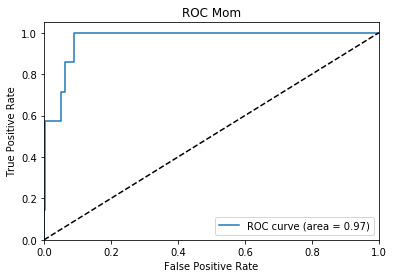

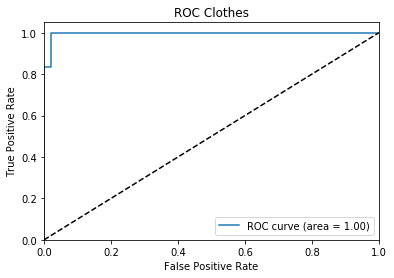

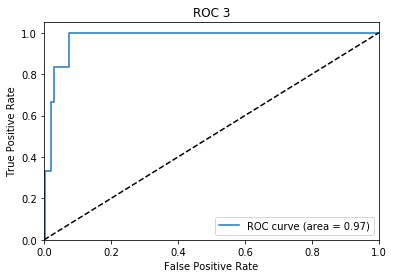

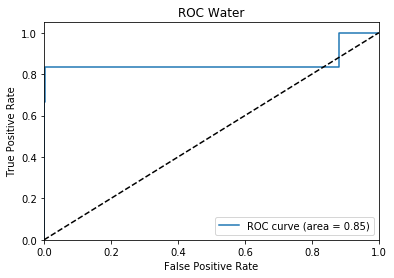

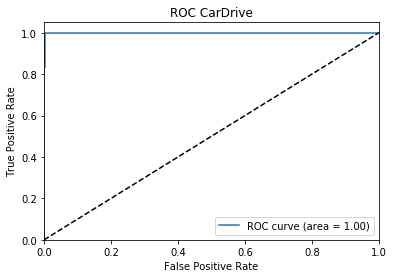

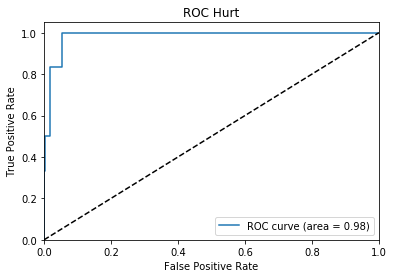

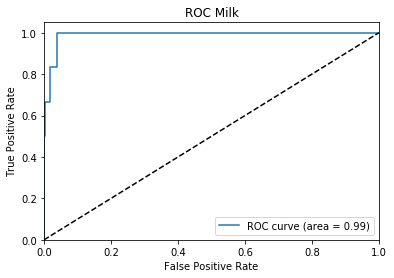

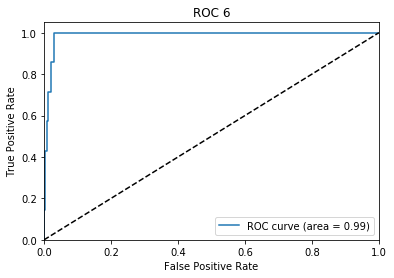

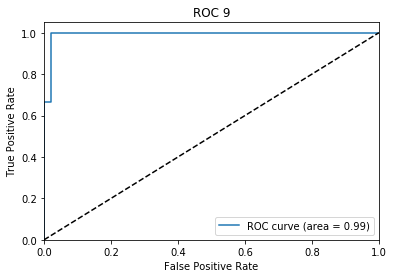

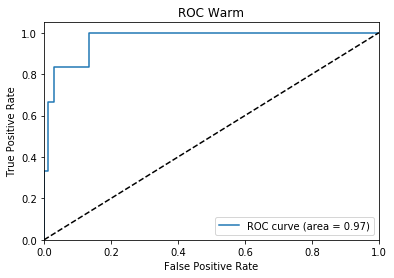

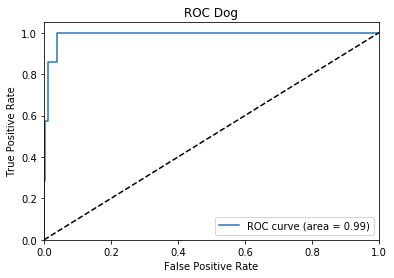

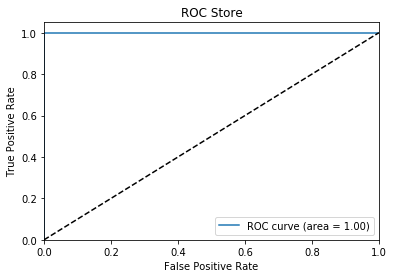

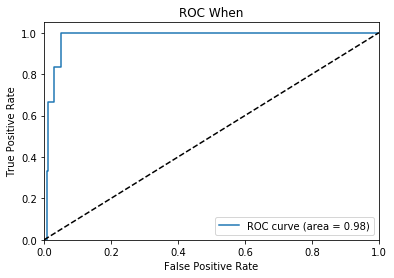

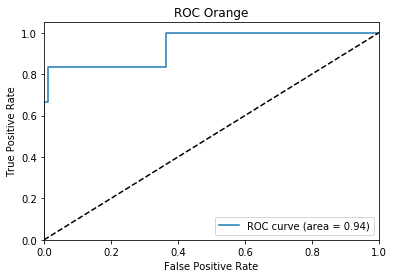

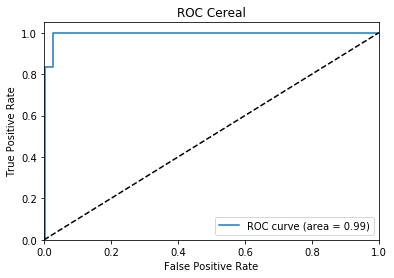

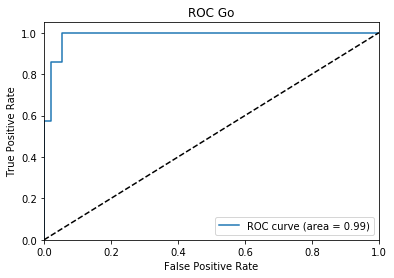

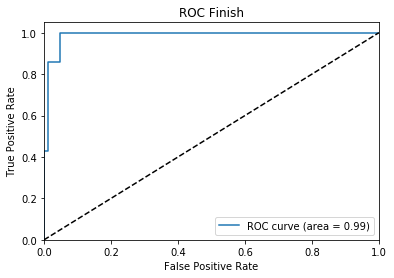

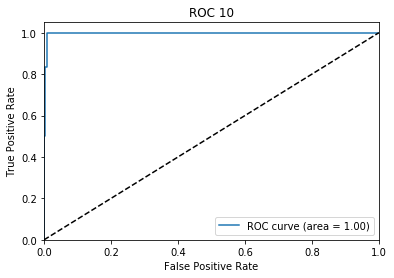

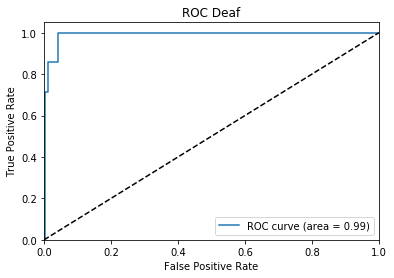

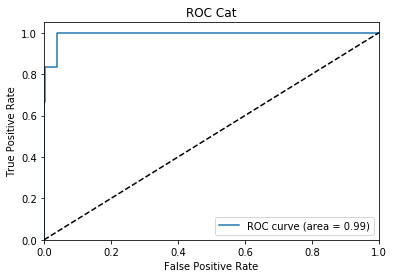

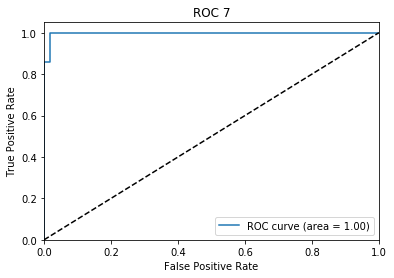

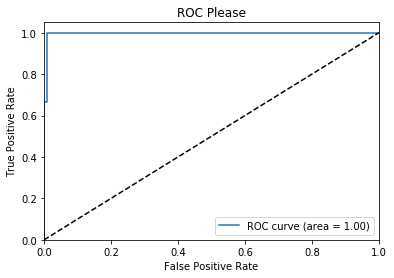

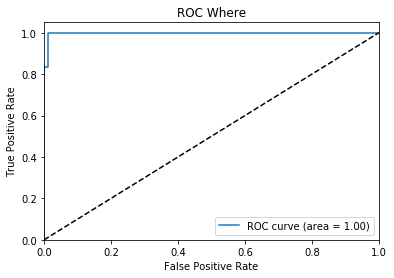

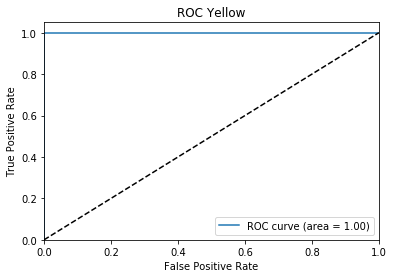

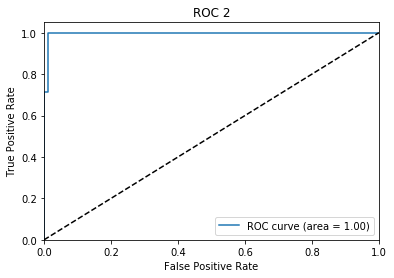

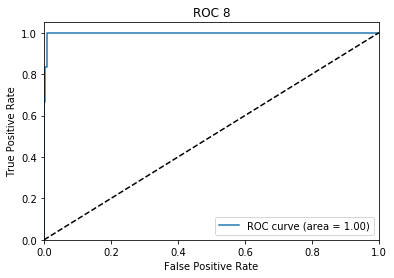

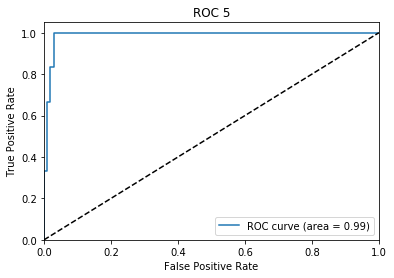

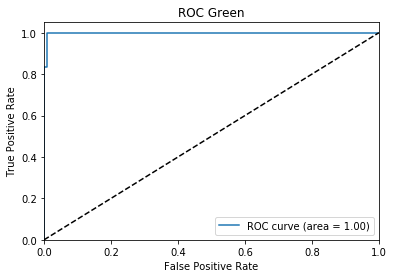

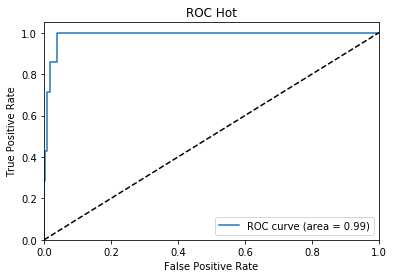

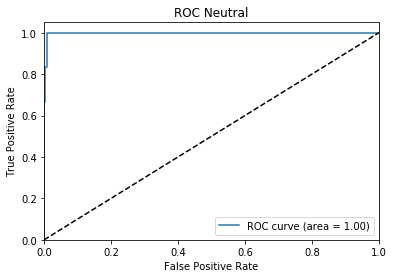

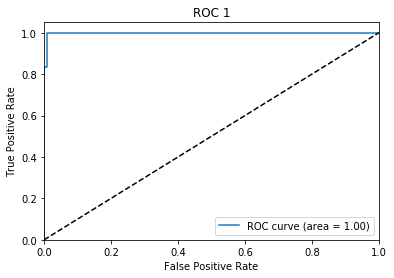

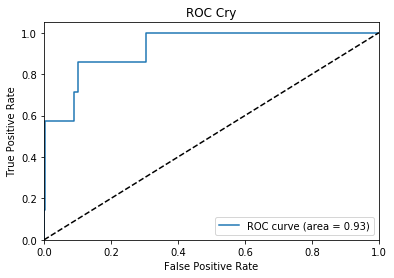

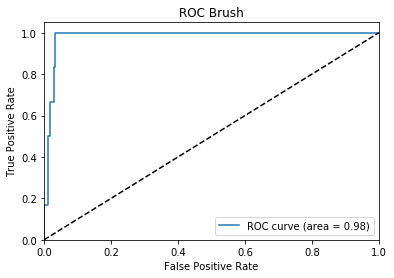

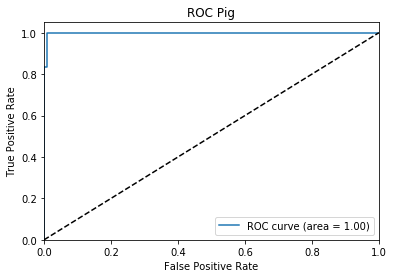

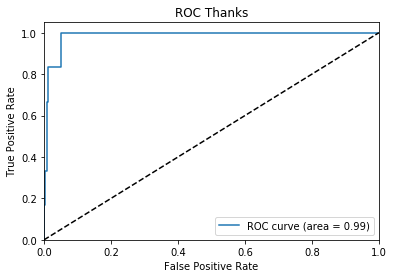

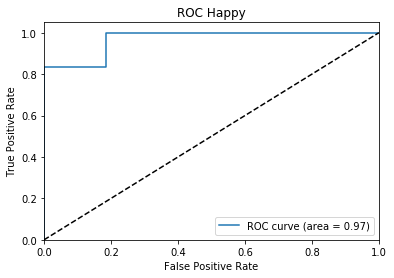

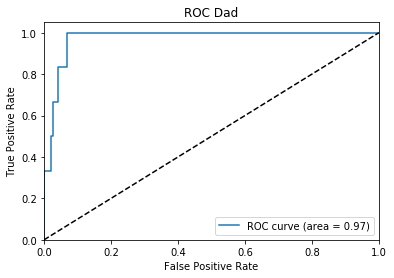

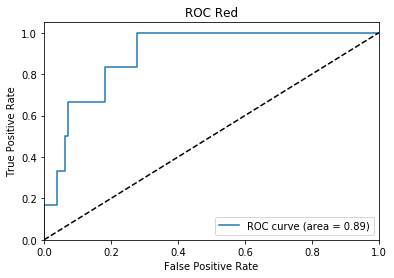

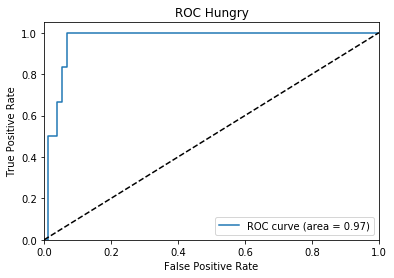

In [196]:
labels = one_hand
n_classes = len(labels)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC ' + labels[i])
    plt.legend(loc="lower right")
    plt.show()